In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
import scipy.stats as ss
import scipy as sc

# Blockchain queue

Blockchain efficiency is characterized by the 
- throughput (how many transactions are confirmed per time unit) 
- latency (the average confirmation time of a transaction). 

These quantities are studied within the frame of a queueing model. 

- The pending transactions arrive at a Poisson rate $\lambda$ to form a queue, 
- a fixed number $b$ (the first which entered the queue) will be processed in a block. 
- The block generation time has distribution $G$ on $\mathbb{R}_+$. 

The result is a $M/G^b/1$ queue. 

We are going to simulate trajectories of this process to study the average confirmation time and the number of pending transaction in the queue at stationarity. 

Let us assume that $G$ is exponential with mean $1/\mu$, which corresponds to the empirical data on the block arrival time in the bitcoin blockchain.

Denote by $(S_i)$ the transaction arrival time and $(T_i)$ the blockarrival times.

We denote by $N_t$ the number of transaction and $M_t$ the number of block up to time $t>0$. Both of the processes are Poisson process with respective intensity $\lambda$ and $\mu$.

The incoming transactions form the queue. When a block is built, some transactions move from the queue to the server via a first in first out discipline. The server may contain at most $b$ transactions which will be part of the next block. 

1. Write a function *MC_queue_blockchain(λ, μ, b, t)* that returns a list with the number of transactions in the server between two block arrival and the average time spent by a transaction in the queue. The queueing process is simulated up to some time horizon $t$, the larger the better in terms of accuracy. Compute the average number of transaction in the server and the average time spent by transactions in the queue with the following parameters

$$
\mu =1, \lambda=2, b=4, t=10000
$$

In [13]:
# MC_queue_blockchain function
def MC_queue_blockchain(λ, μ, b, t):
    # Number of transactions issued and number of blocks generated
    N_t, M_t = np.random.poisson(λ * t), np.random.poisson(μ * t)
    # Transaction and block arrival times
    S, T = np.sort(np.random.uniform(low = 0, high = t, size = N_t)), np.sort(np.random.uniform(low = 0, high = t, size = M_t))
    T = np.insert(T, 0, 0)
    queue = np.array([])
    server = []
    queue_time = []
    for k in range(len(T)-1):    
        queue = np.append(queue, S[np.logical_and(S>T[k], S < T[k+1])])
        if len(queue) > b:
            queue_time.append(np.sum(T[k+1] - queue[:b]))
            server.append(b)
            queue = queue[b:]
        else:
            if len(queue) > 0:
                queue_time.append(np.sum(T[k+1] -queue))
                server.append(len(queue))
                queue = np.array([])
            else:
                server.append(0)
    return(server, np.sum(queue_time) / sum(S < T[-1]))

# Parameters of the transaction arrival, the block size and the service time
μ, λ, b, t  = 1, 2, 4, 10000
print("stationarity condition holds? "+ str(λ < b * μ) )
np.random.seed(1234)
server, queue_time = MC_queue_blockchain(λ, μ, b, t)
np.mean(server), queue_time
# (1.9893808855940693, 1.444426157490472)

stationarity condition holds? True


(1.9893808855940693, 1.444426157490472)

Theoreticaly the mean confirmation time (time spent by a transaction in the queue and then in the server) is given by 

$$
\frac{p}{(1-p)\lambda} +\frac{1}{\mu}
$$
where $p=1/z^\ast$ and $z^\ast$ is the only root to 
$$
-\frac{\lambda}{\mu}z^{b+1}+z^b\left(\frac{\lambda}{\mu}+1\right) - 1,
$$
such that $|z^\ast$|>1.   

Throughput is the average number of transactions being processed per time unit, we have

$$
    \text{Throughput} = \mu\mathbb{E}(N^q\mathbb{I}_{N^q\leq b}+b\mathbb{I}_{N^q> b}) = \mu\sum_{n = 0}^bn(1-p)p^n + bp^{b+1}.
$$

where $N^{q}$ is geometrically distributed random variable with parameter $p$ such that 
$$
\mathbb{P}(N^{q} = n) = (1-p)p^{n},\text{ }n\geq 0
$$
that corresponds to the number of transactions in the queue.

2. Write a function to compute the theoretical troughput and latency. Compare the theoretical throughput and latency to the Monte Carlo approximation provided by the previous function. The parameters are once again

$$
\mu =1, \lambda=2, b=4, t=10000
$$

In [11]:

def exact_latency_throughput(λ, μ, b):

    def f(x):
        return(- λ / μ *x**(b+1) + x**b * (λ / μ + 1) - 1 )

    sol = sc.optimize.root_scalar(f, bracket=[1.00001, 100000], method='brentq')
    p = 1/sol.root
    geom_pmf = np.array([p**k * (1-p) for k in np.arange(0,b+1)])
    latency, throughput = p/(1-p)/λ + 1 / μ, μ*(sum(np.arange(0,b+1) * geom_pmf) + p**(b+1)*b)

    return(latency, throughput)

# Parameters of the transaction arrival, the block size and the service time
μ, λ, b, t  = 1, 2, 4, 10000
print("stationarity condition holds? "+ str(λ < b * μ) )
np.random.seed(1234)
print(exact_latency_throughput(λ, μ, b))
server, queue_time = MC_queue_blockchain(λ, μ, b, t)
print(queue_time + 1/μ, μ * np.mean(N_server))
# (2.432523324276415, 1.9999999999999987)
# 2.444426157490472 1.9893808855940693


stationarity condition holds? True
(2.432523324276415, 1.9999999999999987)
2.444426157490472 1.9893808855940693


3. plot the histogram of the number of transaction in the server using the function *MC_queue_blockchain(λ, μ, b, t)* and the following parameters
$$
\mu =1, \lambda=2, b=4, t=10000
$$
It provides us insight on the server occupancy

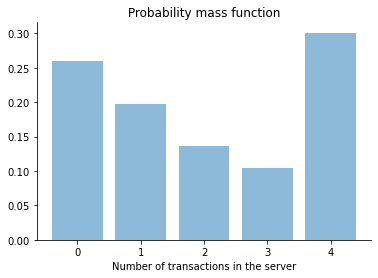

In [14]:
# Parameters of the transaction arrival, the block size and the service time
μ, λ, b, t  = 1, 2, 4, 10000
np.random.seed(1234)
server, queue_time = MC_queue_blockchain(λ, μ, b, t)
plt.bar(np.arange(0, b+1,1), np.array([np.mean(np.array(server)==k) for k in range(b+1)]), alpha = 0.5)
plt.xticks(np.arange(0, b+1,1))
plt.xlabel('Number of transactions in the server')
plt.title('Probability mass function')
sns.despine()